## What is RandomForest?

- A RandomForest is an *ensemble learning method* meaning it builds many DecisionTrees and combines their outputs to make a final prediction.

- For **classification**; it takes a majority vote among all the trees
- For **regression**; it averages the outputs from all trees

- This approach reduces overfitting and variance as compared to simple Decision Trees, while maintaining interpretability and ease of use.

#### Advantages
  1. Reduces Overfitting
  2. Handles Large Datasets well
  3. Works with both classification and regression
  4. Robust to noise and missing data
  5. Provides feature importance metrics

#### Disadvantages
   1. Less interpretable than a single tree
   2. Requires more computational resources as compared with a DecisionTree
   3. May still overfit if trees are too deep or features are poorly engineered.

## RandomForest Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

- First, we need to implement DecisionTree

In [7]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index, self.threshold, self.left, self.right, self.value = feature_index, threshold, left, right, value
    def is_leaf_node(self): return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split, self.max_depth, self.n_feats, self.root = min_samples_split, max_depth, n_feats, None
    def _calculate_mse(self, y):
        if len(y) == 0: return 0
        mean = np.mean(y); return np.mean((y - mean) ** 2)
    def _best_split(self, X, y, feat_indices):
        best_mse, best_split = float('inf'), {}
        for feat_index in feat_indices:
            for threshold in np.unique(X[:, feat_index]):
                left_indices, right_indices = np.where(X[:, feat_index] <= threshold)[0], np.where(X[:, feat_index] > threshold)[0]
                if len(left_indices) > 0 and len(right_indices) > 0:
                    y_left, y_right = y[left_indices], y[right_indices]
                    mse = (len(y_left) / len(y)) * self._calculate_mse(y_left) + (len(y_right) / len(y)) * self._calculate_mse(y_right)
                    if mse < best_mse:
                        best_mse, best_split = mse, {'feature_index': feat_index, 'threshold': threshold, 'left_indices': left_indices, 'right_indices': right_indices}
        return best_split
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or len(np.unique(y)) == 1 or n_samples < self.min_samples_split): return Node(value=np.mean(y))
        feat_indices = np.random.choice(n_features, self.n_feats, replace=False) if self.n_feats else np.arange(n_features)
        best_split = self._best_split(X, y, feat_indices)
        if not best_split: return Node(value=np.mean(y))
        left_indices, right_indices = best_split['left_indices'], best_split['right_indices']
        left_child, right_child = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1), self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        return Node(best_split['feature_index'], best_split['threshold'], left_child, right_child)
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1]); self.root = self._grow_tree(X, y)
    def _traverse_tree(self, x, node):
        if node.is_leaf_node(): return node.value
        return self._traverse_tree(x, node.left) if x[node.feature_index] <= node.threshold else self._traverse_tree(x, node.right)
    def predict(self, X): return np.array([self._traverse_tree(x, self.root) for x in X])


- Now, RandomForest

In [9]:
class RandomForest:
    def __init__(self, n_trees = 100, min_samples_split = 2, max_depth = 100, n_feats = None):
        self.n_trees = n_trees
        self.min_sample_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []
        
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace = True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_sample_split, max_depth=self.max_depth, n_feats=self.n_feats)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis = 0)

In [10]:
X, y = make_regression(n_samples=500, n_features=10, n_informative=5, noise = 20, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForest(n_trees=150, max_depth = 10, n_feats = 6)
model.fit(X_train, y_train)
preds = model.predict(X_test)
mse_err = np.mean((y_test - preds) ** 2)
print(f"RandomForest MSE: {mse_err:.2f}")

RandomForest MSE: 1032.09


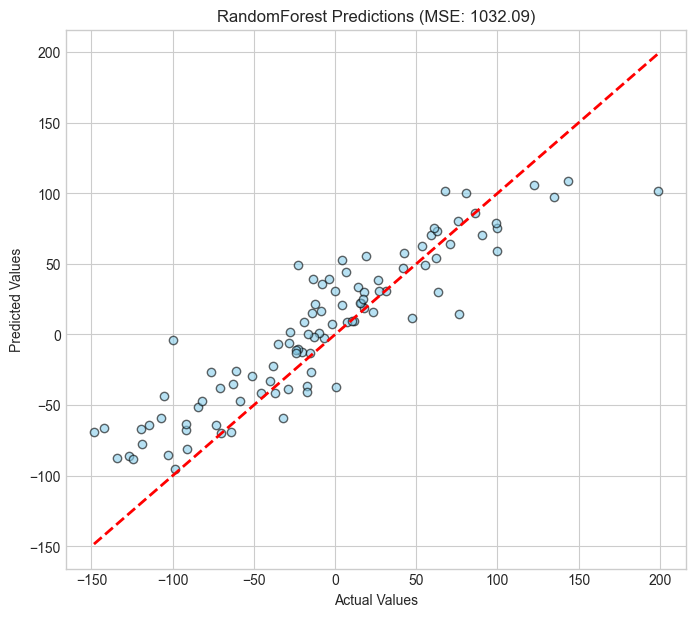

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = (8,7))
plt.scatter(y_test, preds, alpha = 0.6, edgecolors = 'k', c = 'skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),y_test.max()], 'r--', lw = 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"RandomForest Predictions (MSE: {mse_err:.2f})")
plt.show()